<a href="https://colab.research.google.com/github/emanfj/Healthcare-Disparities-Analysis/blob/main/densenet_classification_wheat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

# path to the zip file and the directory to extract to
zip_path = '/content/drive/My Drive/Classification_2.zip'
extract_path = '/content/wheat_classification_data'

# unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [3]:
# list the files in the extracted directory
os.listdir(extract_path)

['Classification_2']

In [4]:
# necessary imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import time
import matplotlib.pyplot as plt

# Architecture for DenseNet

In [5]:
# bottleneck block for dense net
class Bottleneck(nn.Module):
    # constructor to initialize a new instance of the bottleneck
    # arguments-> input channges to the block and growth rate parameter to determine
    # the no of output channels
    def __init__(self, in_channels, growth_rate):
        # constructor of parent class (Module) to initialize Bottleneck class
        super(Bottleneck, self).__init__()
        # 2d batch normalization layer with input channels argument
        self.bn1 = nn.BatchNorm2d(in_channels)
        # initialize the 1st conv layer input channels, output channels, kernel
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        # initialize another 2d batch normalization layer with input channels
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        # initialize second conv layer
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    # define the forward pass of the module taking a tensor 'x' as input
    def forward(self, x):
        # apply batch normalization followed by relu activation and first conv layer to the input tensor and storing the result
        out = self.conv1(F.relu(self.bn1(x)))
        # apply batch normalization, relu activation, second conv layer to the intermediate result
        out = self.conv2(F.relu(self.bn2(out)))
        # concatenate original input tensor with output of second conv layer along with channel dimension i.e 1
        out = torch.cat([x, out], 1)
        # return the concatenated tensor representing the output of bottleneck block
        return out

In [6]:
#definition of transition block-> bw adjacent dense blocks (reduce the no of channels while downsampling the spatial dimensions)
class Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        #2d batch normalization
        self.bn = nn.BatchNorm2d(in_channels)
        # conv layer with input channels,output channels, kernel
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        # avg pooling layer with kernel size 2 for downsampling
        self.pool = nn.AvgPool2d(2)

    # forward pass of the transition module
    def forward(self, x):
        # apply batch normalization, relu activation, conv layer reducing the no of channels thru conv operation
        out = self.conv(F.relu(self.bn(x)))
        # apply avg pooling to the intermediate result reducing the spatial dimension along both the height and width
        out = self.pool(out)
        return out

In [8]:
# architecute for denseNet
# dense connectivity pattern-> each layer receives inputs form all preceding layers
class DenseNet(nn.Module):
    """constructor to initialize a new instance of DenseNet
    block -> bottleneck,transition
    nblocks-> list specifiying the no of blocks on each dense layer
    growth rate-> no of output channels for each individual layer in a dense block
    reduction-> red factor used in transition layer to reduce the no of channels
    num_classes-> no of classes for classification"""
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=3):
        # super constructor for parent class
        super(DenseNet, self).__init__()
        # growth rate
        self.growth_rate = growth_rate

        num_planes = 2 * growth_rate
        # initial conv layer applied to the input imgs to generate feature maps
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        # dense blocks (1,2,3,4) and transition blocks(1,2,3) based on specified no of blocks and growth rate
        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0] * growth_rate
        out_planes = int(num_planes * reduction)
        self.trans1 = Transition(num_planes, out_planes)

        num_planes = out_planes
        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1] * growth_rate
        out_planes = int(num_planes * reduction)
        self.trans2 = Transition(num_planes, out_planes)

        num_planes = out_planes
        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2] * growth_rate
        out_planes = int(num_planes * reduction)
        self.trans3 = Transition(num_planes, out_planes)

        num_planes = out_planes
        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3] * growth_rate

        # batch normalization and linear classifier
        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes * 4 * 4, num_classes)

    # helper method to generate a sequence of dense layers based on the provided parameters
    # creates nblock instances
    def _make_dense_layers(self, block, in_channels, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return nn.Sequential(*layers)

    # forward pass taking tensor as input and passing it thru network
    def forward(self, x):
        # initial conv layer
        out = self.conv1(x)
        # dense and transition layers below
        out = self.trans1(self.dense1(out))

        out = self.trans2(self.dense2(out))

        out = self.trans3(self.dense3(out))

        out = self.dense4(out)
        # batch normalization followed by relu activation
        out = F.relu(self.bn(out))
        # avg pooling
        out = F.avg_pool2d(out, 4)
        # flatten the output
        out = out.view(out.size(0), -1)
        # apply linear classifier for final output
        out = self.linear(out)
        return out


In [21]:
# chain tgthr multiple img transformations for augmentation for better generalization
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # resize to fixed dimensions
    transforms.RandomHorizontalFlip(),  # random hor flip with 50% probability
    transforms.RandomRotation(10),  # random rotation by a max of 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # random changes in brightness, contrast, saturation, and hue
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # random affine transformation with translation
    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # random erasing with 50% probability (for simulating occlusions)
    transforms.ToTensor(),  # convert img to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize tensor img with mean and std dev values bringing the img pixel valu to the range [-1,1] to stabilize training
])

# paths for train and test datasets
train_path = os.path.join(extract_path, 'Classification_2/train')
test_path = os.path.join(extract_path, 'Classification_2/test')

print("Train directory contents:", os.listdir(train_path))
print("Test directory contents:", os.listdir(test_path))

# load datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# split the training data into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# dataloaders for iterating over batches of imgs
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Train directory contents: ['Resistant', 'Healthy', 'Susceptible']
Test directory contents: ['Resistant', 'Healthy', 'Susceptible']


In [13]:
# lists to store training losses and times
train_losses = []
train_times = []
train_accuracies = []
test_accuracies = []
val_losses=[]
val_accuracies=[]

In [23]:
# device selection for gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# instance of the DenseNet model specifying block type, no of dense blocks in each stage,
# growth rate-> no of output feature maps by each layer, no of classes
model = DenseNet(Bottleneck, [6, 12, 24, 16], growth_rate=12, num_classes=3)
# loss function
criterion = nn.CrossEntropyLoss()
# SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=1e-4)

model.to(device)

correct_train = 0
total_train = 0
start_time=time.time()
for epoch in range(30):
    # sets the model to train mode enabling dropout and batch normalization
    model.train()
    # to monitor the running loss during epoch
    running_loss = 0.0
    epoch_start_time=time.time()
    # iterate over batches of input imgs and corresponding labels
    for inputs, labels in train_loader:
        # move data and labels to selected device
        inputs, labels = inputs.to(device), labels.to(device)
        # clear the gradient for optimized parameters
        optimizer.zero_grad()
        # forward pass-> compute the output predictions from the model
        outputs = model(inputs)
        # compute the loss bw the predicted outputs and ground truth labels
        loss = criterion(outputs, labels)
        # backpropagate the gradients
        loss.backward()
        # update the model parameters based on computed gradients and optimizer settings
        optimizer.step()
        # accumulate the batch loss to compute avg loss for the epoch
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate training accuracy
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    epoch_end_time=time.time()
    epoch_time=epoch_end_time - epoch_start_time

    # calculating avg epoch loss
    epoch_loss=running_loss/len(train_loader)
    # append training loss and time to lists
    train_losses.append(epoch_loss)
    train_times.append(epoch_time)

    # validation
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    # print avg loss for the epoch
    print(f"Epoch [{epoch+1}/30], Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

total_train_time = time.time() - start_time
print(f"Total training time: {total_train_time:.2f} seconds")

Epoch [1/30], Train Loss: 0.9070, Train Accuracy: 57.04%, Val Loss: 1.0838, Val Accuracy: 46.43%
Epoch [2/30], Train Loss: 0.6247, Train Accuracy: 64.97%, Val Loss: 0.6090, Val Accuracy: 74.03%
Epoch [3/30], Train Loss: 0.5049, Train Accuracy: 69.65%, Val Loss: 0.5278, Val Accuracy: 76.62%
Epoch [4/30], Train Loss: 0.4455, Train Accuracy: 72.58%, Val Loss: 0.5179, Val Accuracy: 75.65%
Epoch [5/30], Train Loss: 0.4072, Train Accuracy: 74.52%, Val Loss: 0.3950, Val Accuracy: 84.74%
Epoch [6/30], Train Loss: 0.3633, Train Accuracy: 76.27%, Val Loss: 0.3772, Val Accuracy: 85.06%
Epoch [7/30], Train Loss: 0.3741, Train Accuracy: 77.35%, Val Loss: 0.4051, Val Accuracy: 83.44%
Epoch [8/30], Train Loss: 0.3411, Train Accuracy: 78.36%, Val Loss: 1.7353, Val Accuracy: 51.62%
Epoch [9/30], Train Loss: 0.3496, Train Accuracy: 78.90%, Val Loss: 0.3773, Val Accuracy: 81.49%
Epoch [10/30], Train Loss: 0.3210, Train Accuracy: 79.64%, Val Loss: 0.3510, Val Accuracy: 85.71%
Epoch [11/30], Train Loss: 0.

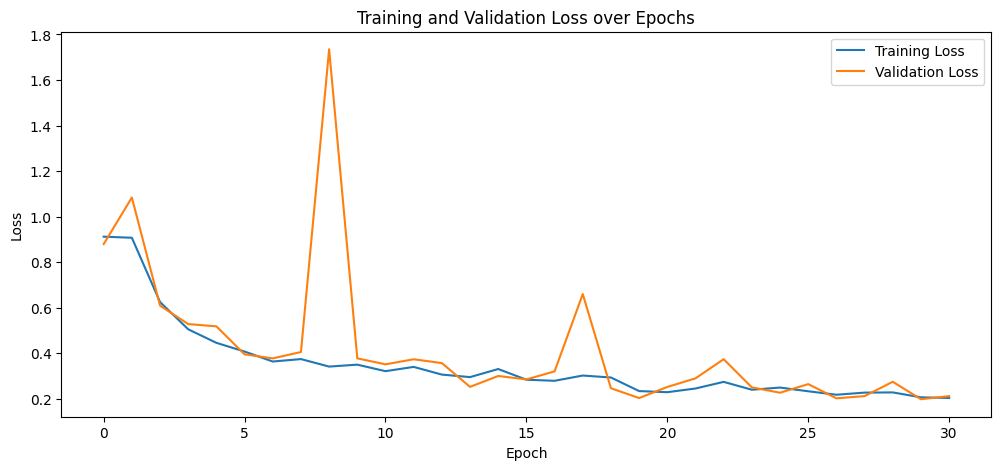

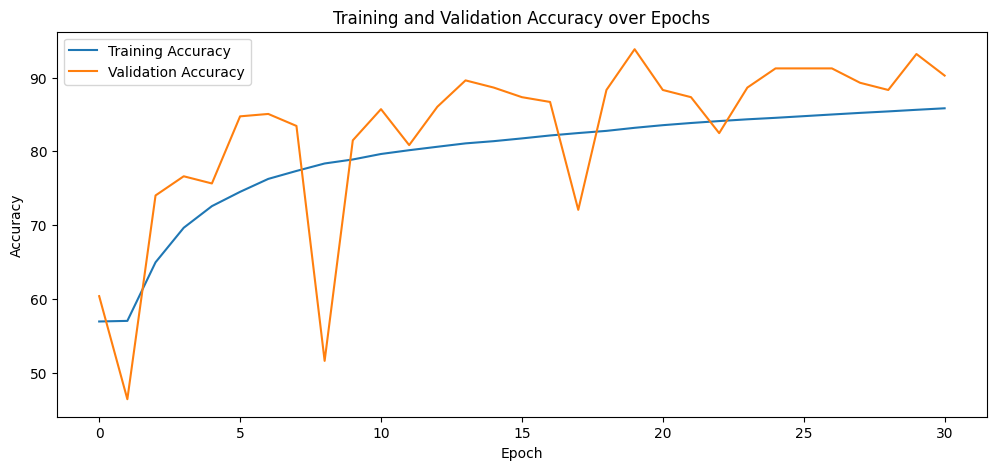

In [24]:
#plotting training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

#plotting the training and validation accuracy
plt.figure(figsize=(12, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

In [25]:
# evalualte the trained model on the test dataset and calc accuracy
# set the model to eval mode disabling dropout and batch normalization
model.eval()
# count no of correclty predicted samples and total samples
correct = 0
total = 0

inference_start_time = time.time()
# disable gradient calculation to speed up computation since gradients arent needed for eval
with torch.no_grad():
    # iterate over batches of input imgs and corresponding labels
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # move data to the GPU
        # forward pass of input data through the model to obtain output predictions
        outputs = model(inputs)
        # for each input sample find the index of class with highest probability
        # torch.max returns both the max value and the index along the dimension (1 for class)
        _, predicted = torch.max(outputs.data, 1)
        # increment the total no of samples processed so far
        total += labels.size(0)
        # compare the predicted labels with ground truth labels
        # sum up correct predictions and update the count
        correct += (predicted == labels).sum().item()

inference_time = time.time() - inference_start_time

# calculate accuracy
print(f"Test Accuracy: {100 * correct / total:.2f}%")
print(f"Inference time: {inference_time:.2f} seconds")


Test Accuracy: 84.38%
Inference time: 5.20 seconds


In [ ]:
# save the model
torch.save(model.state_dict(), '/content/drive/My Drive/dense_net.pth')

In [ ]:
"""
# define the model architecture
model = DenseNet(DenseBlock, [6, 12, 24, 16], growth_rate=12, num_classes=3)

# load the saved model state dictionary
model.load_state_dict(torch.load('dense_net_with_attention.pth'))

# set the model to evaluation mode
model.eval()
"""